# **Step 1: Data Preparation & Splitting (IS vs. OOS)**
**Explanation**: A professional first step is to split our data into two periods:

**1. In-Sample (IS)**: The "training" or "research" period. We will use this data to discover our model (the beta) and optimize parameters.

**2. Out-of-Sample (OOS)**: The "testing" or "validation" period. This data is kept "unseen" to provide an honest, unbiased test of our strategy's real-world performance. This prevents overfitting.

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
import itertools

In [ ]:
tickers = [
    'BMRI.JK', 'BBCA.JK'
]
split_date = '2024-01-01'

In [ ]:
data_full = yf.download(tickers, start='2020-01-01', end='2025-11-07')
data_price = data_full['Close'].dropna()

/tmp/ipython-input-4091796087.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_full = yf.download(tickers, start='2020-01-01', end='2025-11-07')
[*********************100%***********************]  2 of 2 completed


In [ ]:
stocks_A = tickers[0]
stocks_B= tickers[1]

In [ ]:
data_in_sample = data_price[data_price.index < split_date]
data_out_of_sample = data_price[data_price.index >= split_date]

In [ ]:
print(f"In-Sample (IS) Data:  {data_in_sample.index.min().date()} to {data_in_sample.index.max().date()}")
print(f"Out-of-Sample (OOS) Data: {data_out_of_sample.index.min().date()} to {data_out_of_sample.index.max().date()}")

In-Sample (IS) Data:  2020-01-02 to 2023-12-29
Out-of-Sample (OOS) Data: 2024-01-02 to 2025-11-06


# **Cointegration Analysis (In-Sample Only)**

In [ ]:
from statsmodels.tsa.stattools import coint

In [ ]:
score, pvalue, _ = coint(data_in_sample[stocks_A], data_in_sample[stocks_B])

In [ ]:
print(f"P-Value: {pvalue:.4f}")

P-Value: 0.1404


# **Spread Modeling & Hedge Ratio**

In [ ]:
import statsmodels.api as sm

In [ ]:
Y = data_in_sample[stocks_A]
X = data_in_sample[stocks_B]
X_const = sm.add_constant(X)
model = sm.OLS(Y, X_const).fit()
beta = model.params[stocks_B]

In [ ]:
print(beta)
data_price['spread'] = data_price[stocks_A] - (beta * data_price[stocks_B])

0.7960266049913516


# **PARAMETER OPTIMIZATION**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from pandas.core.window import rolling
def run_backtest(data_input, beta, window, entry_thresh, exit_thresh):
    data = data_input.copy()

    data['spread'] = data[stocks_A] - (beta * data[stocks_B])
    rolling_mean = data['spread'].rolling(window=window).mean()
    rolling_std = data['spread'].rolling(window=window).std()
    data['z_score'] = (data['spread'] - rolling_mean) / rolling_std

    data['position'] = np.where(data['z_score'] > entry_thresh, -1, np.nan)
    data['position'] = np.where(data['z_score'] < -entry_thresh, 1, data['position'])
    data['position'] = np.where(abs(data['z_score']) < exit_thresh, 0, data['position'])
    data['position'] = data['position'].ffill().fillna(0)

    data['log_return_A'] = np.log(data[stocks_A] / data[stocks_A].shift(1))
    data['log_return_B'] = np.log(data[stocks_B] / data[stocks_B].shift(1))
    data['strategy_log_return'] = (data['log_return_A'] - (beta * data['log_return_B'])) * data['position'].shift(1)

    data = data.dropna()

    if data.empty:
        return 0, -100, -100, pd.Series()

    daily_log_return = data['strategy_log_return']

    if daily_log_return.std(ddof=1) != 0:
        sharpe_ratio = daily_log_return.mean() / daily_log_return.std(ddof=1)
        annualized_sharpe_ratio = sharpe_ratio * (252**0.5)
    else:
        annualized_sharpe_ratio = 0.0

    total_log_return = daily_log_return.sum()
    total_pct_return = (np.exp(total_log_return) - 1) * 100

    equity_curve = np.exp(daily_log_return.cumsum())
    running_max = equity_curve.cummax()
    drawdown = (equity_curve - running_max) / running_max
    max_drawdown = drawdown.min() * 100

    return annualized_sharpe_ratio, max_drawdown, total_pct_return, daily_log_return

In [ ]:
param_windows = [30, 45, 60]
param_entries = [1.5, 2.0, 2.5, 3.0, 3.5]
param_exits = [0.0, 0.25, 0.5, 1.0]

param_grid = list(itertools.product(param_windows, param_entries, param_exits))
print(len(param_grid))

60


In [ ]:
is_results = []

In [ ]:
for params in param_grid:
    window, entry, exit_thresh = params
    sharpe, mdd, ret, _ = run_backtest(data_in_sample, beta,
                                     window, entry, exit_thresh)
    is_results.append({
        'window': window, 'entry': entry, 'exit': exit_thresh,
        'sharpe': sharpe, 'mdd': mdd, 'return': ret
    })

In [ ]:
is_results_df = pd.DataFrame(is_results).sort_values(by='sharpe', ascending=False)
best_params = is_results_df.iloc[0]

In [ ]:
print("--- IN-SAMPLE OPTIMIZATION RESULTS (TOP 5) ---")
print(is_results_df.head().to_string())

--- IN-SAMPLE OPTIMIZATION RESULTS (TOP 5) ---
    window  entry  exit    sharpe        mdd      return
3       30    1.5  1.00  2.191611 -14.289981  369.323243
23      45    1.5  1.00  2.016370 -10.353051  273.650904
22      45    1.5  0.50  1.978692 -13.006922  345.381631
43      60    1.5  1.00  1.923287  -9.716553  200.560951
5       30    2.0  0.25  1.897297 -14.087785  333.503693


In [ ]:
print(f"Window: {best_params['window']}")
print(f"Entry: {best_params['entry']}")
print(f"Exit: {best_params['exit']}")
print(f"Sharpe (In-Sample): {best_params['sharpe']:.2f}")

Window: 30.0
Entry: 1.5
Exit: 1.0
Sharpe (In-Sample): 2.19


In [ ]:
pivot_table = is_results_df[is_results_df['window'] == best_params['window']]
pivot = pivot_table.pivot_table(values='sharpe', index='entry', columns='exit')

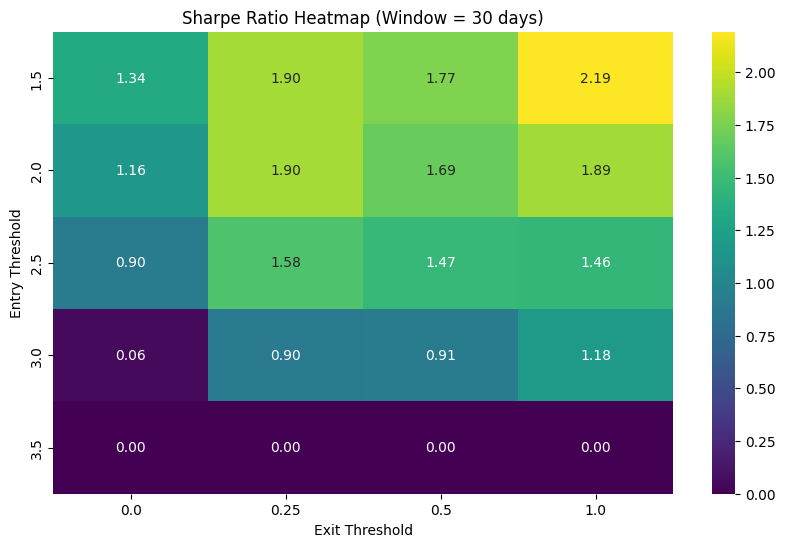

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="viridis")
plt.title(f"Sharpe Ratio Heatmap (Window = {int(best_params['window'])} days)")
plt.xlabel("Exit Threshold")
plt.ylabel("Entry Threshold")
plt.show()

# **Out-of-Sample Validation (The Final Test)**

In [ ]:
best_window = int(best_params['window'])
best_entry = best_params['entry']
best_exit = best_params['exit']

In [ ]:
oos_sharpe, oos_mdd, oos_ret, oos_log_returns = run_backtest(
  data_out_of_sample, beta,
  best_window,
  best_entry,
  best_exit)

In [ ]:
print(f"Sharpe Ratio (OOS): {oos_sharpe:.2f}")
print(f"Maximum Drawdown (OOS): {oos_mdd:.2f}%")
print(f"Total Return (OOS): {oos_ret:.2f}%")

Sharpe Ratio (OOS): 2.08
Maximum Drawdown (OOS): -8.06%
Total Return (OOS): 78.55%


# **Final Evaluation & Visualizations**

In [ ]:
_, _, _, is_log_returns = run_backtest(data_in_sample, beta, best_window, best_entry, best_exit)

In [ ]:
equity_is = 100 * np.exp(is_log_returns.cumsum())
equity_oos = 100 * np.exp(oos_log_returns.cumsum())
equity_oos_stitched = equity_is.iloc[-1] * equity_oos / equity_oos.iloc[0]

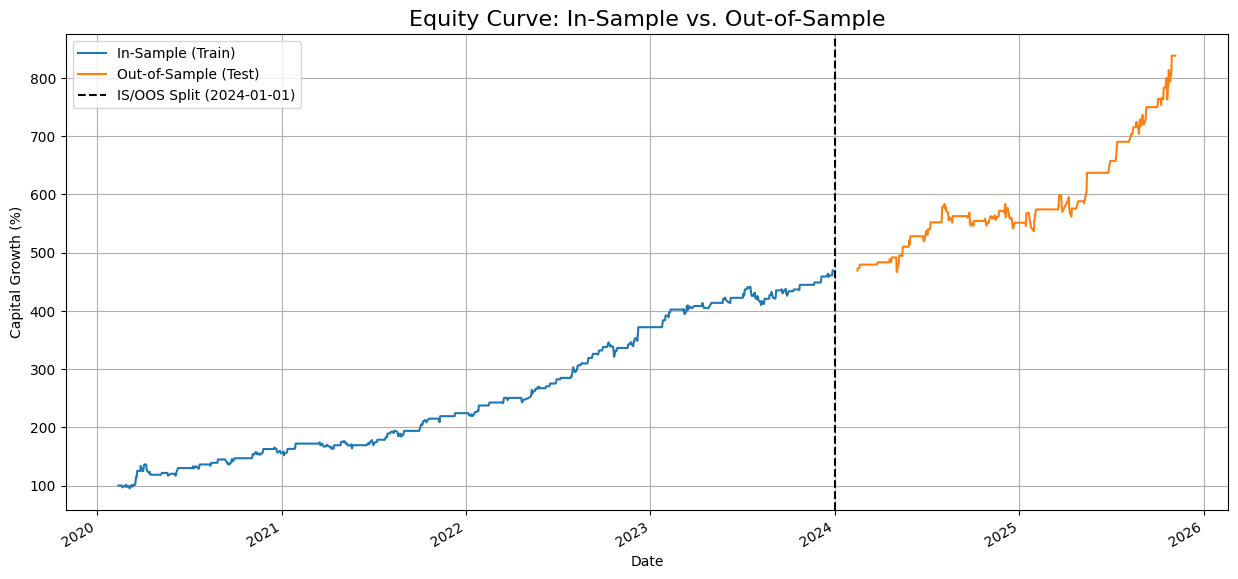

In [ ]:
plt.figure(figsize=(15, 7))
equity_is.plot(label='In-Sample (Train)')
equity_oos_stitched.plot(label='Out-of-Sample (Test)')

plt.axvline(pd.to_datetime(split_date), color='black', linestyle='--', label=f'IS/OOS Split ({split_date})')
plt.title("Equity Curve: In-Sample vs. Out-of-Sample", fontsize=16)
plt.ylabel("Capital Growth (%)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
data_oos_viz = data_out_of_sample.copy()
data_oos_viz['spread'] = data_oos_viz[stocks_A] - (beta * data_oos_viz[stocks_B])
rolling_mean = data_oos_viz['spread'].rolling(window=best_window).mean()
rolling_std = data_oos_viz['spread'].rolling(window=best_window).std()
data_oos_viz['z_score'] = (data_oos_viz['spread'] - rolling_mean) / rolling_std
data_oos_viz = data_oos_viz.dropna()

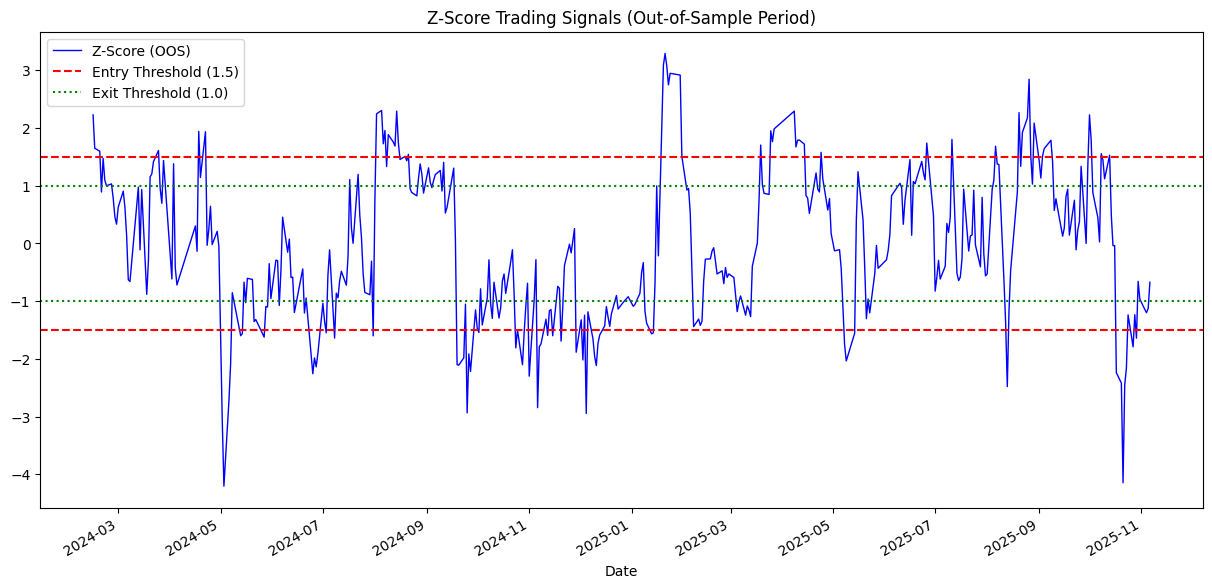

In [ ]:
plt.figure(figsize=(15, 7))
data_oos_viz['z_score'].plot(label='Z-Score (OOS)', color='blue', linewidth=1)
plt.axhline(best_entry, color='red', linestyle='--', label=f'Entry Threshold ({best_entry})')
plt.axhline(-best_entry, color='red', linestyle='--')
plt.axhline(best_exit, color='green', linestyle=':', label=f'Exit Threshold ({best_exit})')
plt.axhline(-best_exit, color='green', linestyle=':')
plt.title("Z-Score Trading Signals (Out-of-Sample Period)")
plt.legend()
plt.show()

In [ ]:
_, _, _, pairs_log_returns = run_backtest(data_price, beta,
                                          best_window, best_entry, best_exit)
pairs_log_returns.name = 'Pairs_Strategy'

In [ ]:
bh_log_returns_A = np.log(data_price[stocks_A] / data_price[stocks_A].shift(1))
bh_log_returns_A.name = f'Buy_Hold_{stocks_A}'

In [ ]:
bh_log_returns_B = np.log(data_price[stocks_B] / data_price[stocks_B].shift(1))
bh_log_returns_B.name = f'Buy_Hold_{stocks_B}'

In [ ]:
all_returns = pd.concat([pairs_log_returns, bh_log_returns_A, bh_log_returns_B], axis=1)
all_returns = all_returns.dropna()

In [ ]:
cumulative_log_returns = all_returns.cumsum()
equity_curves = 100 * np.exp(cumulative_log_returns)

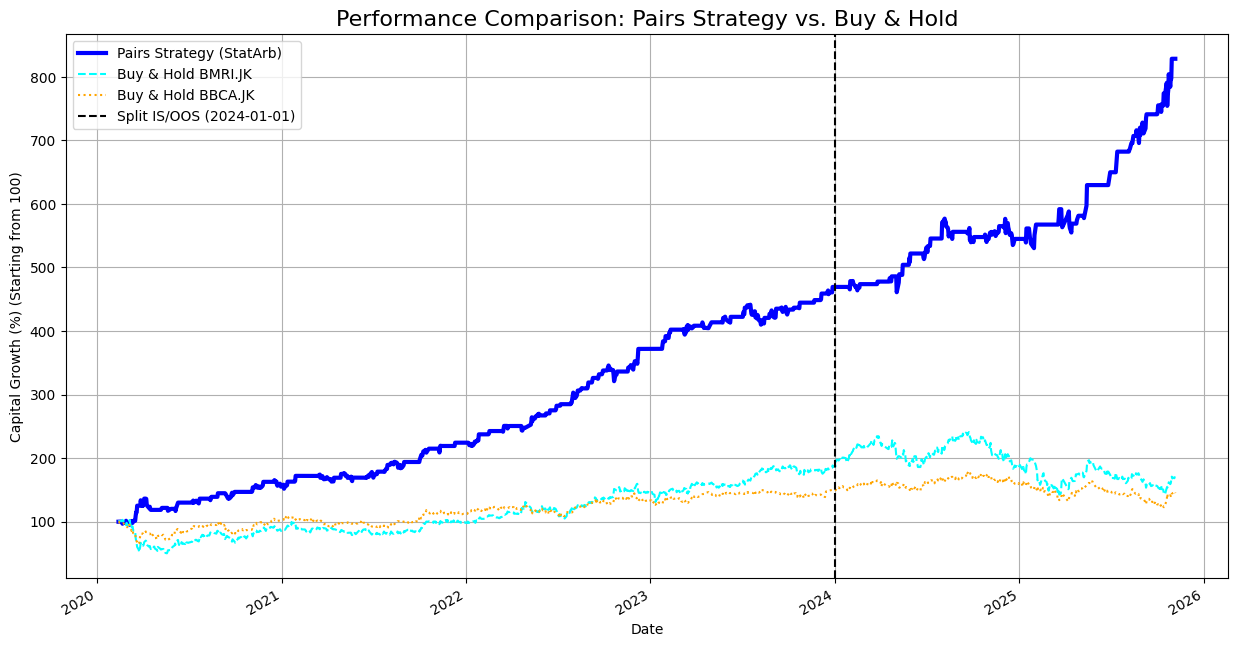

In [ ]:
plt.figure(figsize=(15, 8))
equity_curves['Pairs_Strategy'].plot(label='Pairs Strategy (StatArb)', linewidth=3, color='blue')
equity_curves[f'Buy_Hold_{stocks_A}'].plot(label=f'Buy & Hold {stocks_A}', linestyle='--', color='cyan')
equity_curves[f'Buy_Hold_{stocks_B}'].plot(label=f'Buy & Hold {stocks_B}', linestyle=':', color='orange')

plt.axvline(pd.to_datetime(split_date), color='black', linestyle='--',
            label=f'Split IS/OOS ({split_date})')

plt.title('Performance Comparison: Pairs Strategy vs. Buy & Hold', fontsize=16)
plt.ylabel('Capital Growth (%) (Starting from 100)')
plt.xlabel('Date')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
start_val = equity_curves.iloc[0]
end_val = equity_curves.iloc[-1]

total_return_pct = (end_val / start_val - 1) * 100

print("Total Return (%):")
print(total_return_pct.to_string(float_format="%.2f%%"))

Total Return (%):
Pairs_Strategy     728.26%
Buy_Hold_BMRI.JK    68.55%
Buy_Hold_BBCA.JK    44.51%
